In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import datetime as dt

import json
import urllib.request

import matplotlib.pyplot as plt
import os

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

# Load in json files

In [2]:
def findFilesInFolder(path, pathList, extension, subFolders = True):
    try:   # Trapping a OSError:  File permissions problem I believe
        for entry in os.scandir(path):
            if entry.is_file() and entry.path.endswith(extension):
                pathList.append(entry.path)
            elif entry.is_dir() and subFolders: 
                pathList = findFilesInFolder(entry.path, pathList,
                                             extension, subFolders)
    except OSError:
        print('Cannot access ' + path +'. Probably a permissions error')
    return pathList

dir_name_el = '../data/out/'
extension_el = '.json'
pathList_el = []
flist_el = findFilesInFolder(dir_name_el, pathList_el, extension_el, True)
flist_el = sorted(flist_el)
print(len(flist_el),"files total. E.g.:")
flist_el[:5]

208 files total. E.g.:


['../data/out/schools-collection_1798.json',
 '../data/out/schools-collection_Accessories.json',
 '../data/out/schools-collection_Agents.json',
 '../data/out/schools-collection_Agriculture.json',
 '../data/out/schools-collection_Animal husbandry.json']

# Example

In [3]:
example_fn = flist_el[181]

In [4]:
with open(example_fn) as x:
    dat_i = json.load(x)

In [5]:
print(example_fn.replace(dir_name_el,''),
      "-- contains",len(dat_i),"entries. Keys:")
list(dat_i.keys())[:5]

schools-collection_The great famine.json -- contains 3926 entries. Keys:


['4428270/4390292/4429228',
 '4427865/4351855/4434407',
 '4428183/4384591/4434575',
 '4428270/4390301/4435001',
 '4428270/4390317/4435015']

In [6]:
ex = 0
list(dat_i.values())[ex]

{'title': 'A Tragic Accident',
 'bib': ['Archival Reference',
  'The Schools’ Collection, Volume 1032, Page 002',
  'Page 002'],
 'url': 'https://www.duchas.ie/en/cbes/4428270/4390292/4429228',
 'text': '\nA sad tragedy occurred on Saturday last the 30th October, 1937 when Mr. Albert Flood who had for some time been driving in Laghey was accidentally killed on his way to Pettigo. The sad occurrence happened while he was cycling past the stone breaker on the main road about four miles from Laghey. It appears the unfortunate man raised his hand from the handle of the bicycle to salute the driver of the roller when his bicycle slipped and he was thrown off against the roller. He received such terrible injuries to his head that he died immediately. At the inquest which was subsequently held the driver of the roller was exonerated from all blame.\n',
 'school_info': 'School: Shannagh',
 'metadata': [{'Location:': 'Shannagh, Co. Donegal',
   'Teacher:': '\nJ. Hutchman\n'},
  {'Collector': 'R

In [7]:
text_ex = list(dat_i.values())[ex]['text'].replace('\n','')
text_ex

'A sad tragedy occurred on Saturday last the 30th October, 1937 when Mr. Albert Flood who had for some time been driving in Laghey was accidentally killed on his way to Pettigo. The sad occurrence happened while he was cycling past the stone breaker on the main road about four miles from Laghey. It appears the unfortunate man raised his hand from the handle of the bicycle to salute the driver of the roller when his bicycle slipped and he was thrown off against the roller. He received such terrible injuries to his head that he died immediately. At the inquest which was subsequently held the driver of the roller was exonerated from all blame.'

# Span through all entries

In [8]:
import re

In [9]:
english_stopwords = ['continued','next','page',"","a","about","above","after",
            "again","against","ain","all","am","an","and","any","are","aren",
            "aren't","as","at","be","because","been","before","being",
            "below","between","both","but","by","can","couldn","couldn't",
            "d","did","didn","didn't","do","does","doesn","doesn't",
            "doing","don","don't","down","during","each","few","for",
            "from","further","had","hadn","hadn't","has","hasn","hasn't",
            "have","haven","haven't","having","he","her","here","hers",
            "herself","him","himself","his","how","i","if","in","into",
            "is","isn","isn't","it","it's","its","itself","just","ll",
            "m","ma","me","mightn","mightn't","more","most","mustn",
            "mustn't","my","myself","needn","needn't","no","nor","not",
            "now","o","of","off","on","once","only","or","other","our",
            "ours","ourselves","out","over","own","re","s","same","shan",
            "shan't","she","she's","should","should've","shouldn","shouldn't",
            "so","some","such","t","than","that","that'll","the","their",
            "theirs","them","themselves","then","there","these","they",
            "this","those","through","to","too","under","until","up",
            "ve","very","was","wasn","wasn't","we","were","weren","weren't",
            "what","when","where","which","while","who","whom","why","will",
            "with","won","won't","wouldn","wouldn't","y","you","you'd",
            "you'll","you're","you've","your","yours","yourself","yourselves",
            "could","he'd","he'll","he's","here's","how's","i'd","i'll",
            "i'm","i've","let's","ought","she'd","she'll","that's",
            "there's","they'd","they'll","they're","they've","we'd",
            "we'll","we're","we've","what's","when's","where's",
            "who's","why's","would"]

irish_stopwords = ["a","ach","ag","agus","an","aon","ar","arna","as","b'","ba",
            "beirt","bhúr","caoga","ceathair","ceathrar","chomh","chtó",
            "chuig","chun","cois","céad","cúig","cúigear","d'","daichead",
            "dar","de","deich","deichniúr","den","dhá","do","don","dtí",
            "dá","dár","dó","faoi","faoin","faoina","faoinár","fara",
            "fiche","gach","gan","go","gur","haon","hocht","i","iad",
            "idir","in","ina","ins","inár","is","le","leis","lena","lenár",
            "m'","mar","mo","mé","na","nach","naoi","naonúr","ná","ní",
            "níor","nó","nócha","ocht","ochtar","os","roimh","sa","seacht",
            "seachtar","seachtó","seasca","seisear","siad","sibh","sinn",
            "sna","sé","sí","tar","thar","thú","triúr","trí","trína",
            "trínár","tríocha","tú","um","ár","é","éis","í","ó","ón","óna","ónár"]

In [10]:
all_words = []
for entry_id, data_i in dat_i.items():
    text_i = data_i['text'].replace('\n','')
    for w in text_i.split(' '):
        add_word = re.sub(r'[^\w\s]','',w).lower()
        if add_word not in irish_stopwords and add_word not in english_stopwords:
            all_words.append(add_word)

In [11]:
sorted_word_freq = {k: v for k, v in sorted(dict(Counter(all_words)).items(),
                                            key=lambda item: item[1], reverse=True)}

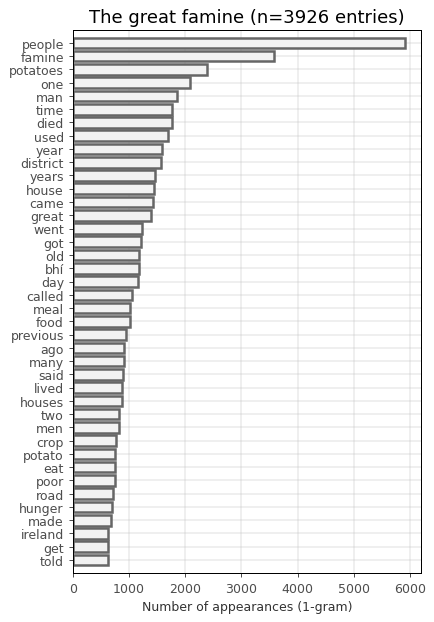

In [12]:
nwords = 40
fig, ax = plt.subplots(1,1,figsize=(5,8),dpi=90)

for ix,i in enumerate(list(sorted_word_freq)[:nwords]):
    ax.barh(ix+1, sorted_word_freq[i], ec='.4', fc='.95', lw=2,)

ax.set_yticks(np.linspace(nwords,1,nwords))
ax.set_yticklabels([i for i in list(sorted_word_freq)[:nwords][::-1]])
ax.set_ylim(nwords+1,0)
ax.grid(lw=1.5, color='.75', alpha=0.25)
ax.tick_params(labelcolor='.3', color='.3')
ax.set_xlabel('Number of appearances (1-gram)', color='.2')
ax.set_title(example_fn.replace(dir_name_el,'').split('_')[-1].replace('.json','')+\
             ' (n=%i entries)'%(len(dat_i)),
             fontsize='x-large')

plt.savefig('../figs/pngs/schools_GreatFamine_1grams.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/schools_GreatFamine_1grams.pdf',bbox_inches='tight')

plt.show()

___________

In [13]:
all_2grams = []
for entry_id, data_i in dat_i.items():
    text_i = data_i['text'].replace('\n','')
    text_i_new = []
    for w in text_i.split(' '):
        add_word = re.sub(r'[^\w\s]','',w).lower()
        if add_word not in irish_stopwords and add_word not in english_stopwords:
            text_i_new.append(add_word)

    text_i = " ".join(text_i_new)
    for i in english_stopwords:
        if len(i)>1:
            text_i = text_i.replace(" "+i+" ",'').replace('  ',' ')

    for i in irish_stopwords:
        if len(i)>1:
            text_i = text_i.replace(" "+i+" ",'').replace('  ',' ')

    text = [text_i]
    bigrams = [b for l in text for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]

    for bg in bigrams:
        all_2grams.append(bg)

In [14]:
sorted_2gram_freq = {k: v for k, v in sorted(dict(Counter(all_2grams)).items(),
                                            key=lambda item: item[1], reverse=True)}

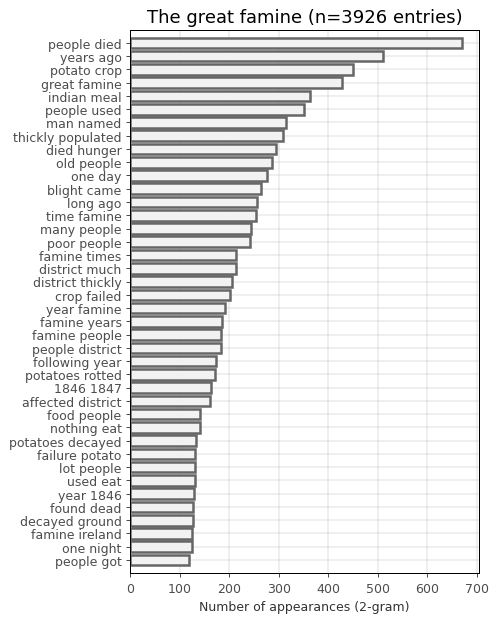

In [15]:
nwords = 40
fig, ax = plt.subplots(1,1,figsize=(5,8),dpi=90)

for ix,i in enumerate(list(sorted_2gram_freq)[:nwords]):
    ax.barh(ix+1, sorted_2gram_freq[i], ec='.4', fc='.95', lw=2,)

ax.set_yticks(np.linspace(nwords,1,nwords))
ax.set_yticklabels([" ".join(i) for i in list(sorted_2gram_freq)[:nwords][::-1]])
ax.set_ylim(nwords+1,0)
ax.grid(lw=1.5, color='.75', alpha=0.25)
ax.tick_params(labelcolor='.3', color='.3')
ax.set_xlabel('Number of appearances (2-gram)', color='.2')
ax.set_title(example_fn.replace(dir_name_el,'').split('_')[-1].replace('.json','')+\
             ' (n=%i entries)'%(len(dat_i)),
             fontsize='x-large')

plt.savefig('../figs/pngs/schools_GreatFamine_2grams.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/schools_GreatFamine_2grams.pdf',bbox_inches='tight')

plt.show()

________________

# Create a collector-informant network

In [16]:
import networkx as nx

In [17]:
G = nx.DiGraph()
edgelist = []
edgemeta = []
for entry_id, data_i in dat_i.items():
    col_list = [i for i in data_i['metadata'] if 'Collector' in list(i.keys())]
    inf_list = [i for i in data_i['metadata'] if 'Informant' in list(i.keys())]

    if len(col_list) > 0 and len(inf_list) > 0:
        collector_i = col_list[0]
        informant_i = inf_list[0]
        node_i = collector_i['Collector'].replace('/n','')
        node_j = informant_i['Informant'].replace('/n','')
        if node_j == '(name not given)':
            continue
        eij = (node_i+' - collector',node_j+' - informant')
#         att = {'Gender':''}

#         if "Gender" in list(collector_i.keys()) and "Gender" in list(informant_i.keys()):
#             att['Gender'] = collector_i['Gender'].lower()+'-'+informant_i['Gender'].lower()
            
        G.add_edge(eij[0],eij[1])#,gender=att['Gender'])


In [18]:
giant = max(nx.weakly_connected_components(G), key=len)
print(len(giant),'nodes in the largest weakly connected component')

13 nodes in the largest weakly connected component


/usr/local/anaconda3/envs/covid/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


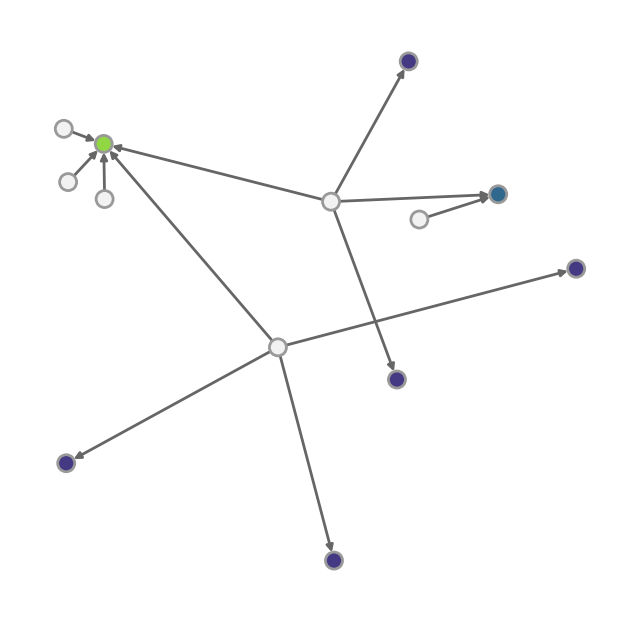

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=100)
Gp = nx.subgraph(G,giant)
indegs = np.array(list(dict(Gp.in_degree()).values()))
indegs = indegs / (max(indegs)+1)
indegs_cols = plt.cm.viridis(indegs)
ncs = [indegs_cols[ix] if i>0 else '.95' for ix,i in enumerate(indegs)]
pos = nx.kamada_kawai_layout(Gp)
pos = nx.spring_layout(Gp,pos=pos,iterations=20)
nx.draw(Gp,pos,edge_color='.4',edgecolors='.6',node_color=ncs,
        linewidths=2.0,node_size=150,width=2.0)

plt.savefig('../figs/pngs/schools_GreatFamine_giantcomponent.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/schools_GreatFamine_giantcomponent.pdf',bbox_inches='tight')

plt.show()

______________

# Do the same thing but across several topics

In [20]:
G = nx.DiGraph()
full_data = {}

for fi,fn_i in enumerate(flist_el[:50]):
    with open(fn_i) as x:
        dat_i = json.load(x)
    
    for entry, data_i in dat_i.items():
        if entry not in list(full_data.keys()):
            full_data[entry] = data_i

            col_list = [i for i in data_i['metadata'] if 'Collector' in list(i.keys())]
            inf_list = [i for i in data_i['metadata'] if 'Informant' in list(i.keys())]

            if len(col_list) > 0 and len(inf_list) > 0:
                collector_i = col_list[0]
                informant_i = inf_list[0]
                node_i = collector_i['Collector'].replace('/n','')
                node_j = informant_i['Informant'].replace('/n','')
                if node_j == '(name not given)':
                    continue
                eij = (node_i+' - collector',node_j+' - informant')
#                 att = {'Gender':''}

#                 if "Gender" in list(collector_i.keys()) and "Gender" in list(informant_i.keys()):
#                     att['Gender'] = collector_i['Gender'].lower()+'-'+informant_i['Gender'].lower()

                G.add_edge(eij[0],eij[1])#,gender=att['Gender'])

In [21]:
giant = max(nx.weakly_connected_components(G), key=len)
print(len(giant),'nodes in the largest weakly connected component')

101 nodes in the largest weakly connected component


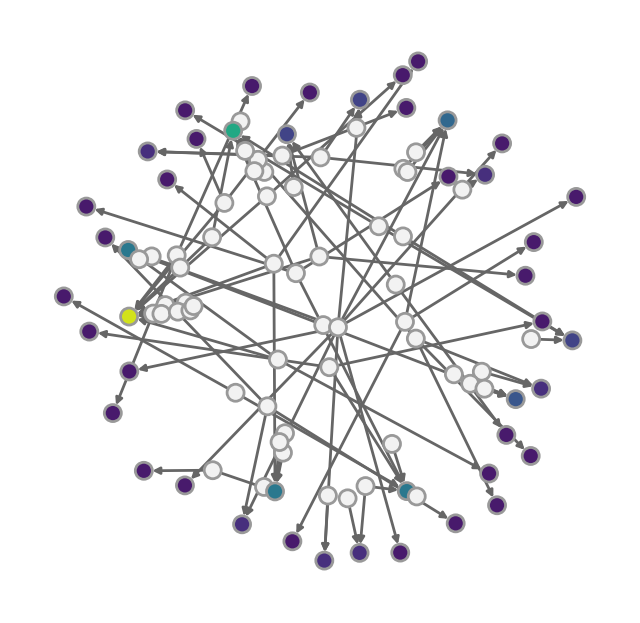

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=100)
Gp = nx.subgraph(G,giant)
indegs = np.array(list(dict(Gp.in_degree()).values()))
indegs = indegs / (max(indegs)+1)
indegs_cols = plt.cm.viridis(indegs)
ncs = [indegs_cols[ix] if i>0 else '.95' for ix,i in enumerate(indegs)]
pos = nx.kamada_kawai_layout(Gp)
pos = nx.spring_layout(Gp,pos=pos,iterations=20)
nx.draw(Gp,pos,edge_color='.4',edgecolors='.6',node_color=ncs,
        linewidths=2.0,node_size=150,width=2.0)

plt.savefig('../figs/pngs/schools_subset_giantcomponent.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/schools_subset_giantcomponent.pdf',bbox_inches='tight')

plt.show()

___________